In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from utils import *
from matplotlib.patches import Ellipse

In [12]:
def get_J(params): 
    c = params[3] 
    J = np.array([[-params[0], params[2]], [-params[0]*c, -params[1]+c*params[2]]])
    return J 

def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    c = params[3]
    b = params[4]
    J = np.array([[-params[0], params[2]], [-params[0]*c, -params[1]+c*params[2]]])
    B = np.diagflat(params[-2:])**2 
    B[1, 1] += c*c*B[0, 0]
    B[1, 0] = c*B[0, 0] + 3*b*B[0, 0]**2 
    B[0, 1] = B[1, 0] 
    return J, B 

def get_B(B0, b, c, h_dot_det):
    f = 3*b*(h_dot_det**2)
    Bt = np.copy(B0) 
    Bt[1, 0] += f*Bt[0, 0]
    Bt[0, 1] = Bt[1, 0] 
    Bt[1, 1] += (f**2 + 2*f*c)*Bt[0, 0]  + 3*(f+c)*b*(Bt[0, 0]**2)
    return Bt

In [4]:
# params in the order of epsilon, gamma, mu, c 
mu = 0.16884
c = 5.48681
gamma = 2.38254 + c*mu

N = 100
epsilons = np.linspace(0.0001, 1, N)
mus = np.linspace(0.01, 1, N)

Re = np.empty((N, N))
Im = np.empty((N, N))

for (i, epsilon) in enumerate(epsilons): 
    for (j, mu) in enumerate(mus):
        J = get_J([epsilon, gamma, mu, c]) 
        eigvals = np.linalg.eigvals(J)
        Re[i, j] = np.real(np.max(eigvals))
        Im[i, j] = np.imag(np.max(eigvals))

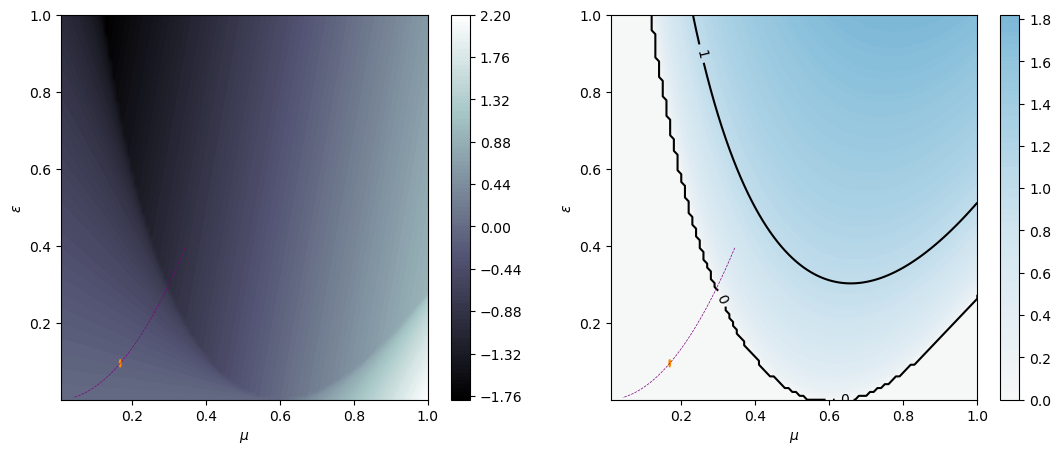

In [8]:
epsilon_map = 0.09473
epsilon_frac_err = 0.09703*1.96

mu_map = 0.16884
mu_frac_err = 0.01126*1.96

centre = [mu_map, epsilon_map]
width = mu_frac_err*mu_map 
height = epsilon_frac_err*epsilon_map

ratios = np.linspace(0.7, 2, 100)
mu_traj = mu_map/ratios**2
epsilon_traj = epsilon_map/ratios**4 



ellipse =  Ellipse(centre, width, height, fill=True, color='darkorange')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

im = axes[0].contourf(mus, epsilons, Re, levels=100, cmap='bone')
axes[0].add_patch(ellipse)
axes[0].set_xlabel(r'$\mu$')
axes[0].set_ylabel(r'$\epsilon$')
axes[0].plot(mu_traj, epsilon_traj, '--', color='purple', linewidth=0.5)
fig.colorbar(im, ax=axes[0])

im = axes[1].contourf(mus, epsilons, Im, levels=100, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar(im, ax=axes[1])
CS = axes[1].contour(mus, epsilons, Im, levels=[0, 1], colors='black')
axes[1].clabel(CS, inline=True, fontsize=10)
axes[1].set_xlabel(r'$\mu$')
axes[1].set_ylabel(r'$\epsilon$')
ellipse =  Ellipse(centre, width, height, fill=True, color='darkorange')
axes[1].add_patch(ellipse)
axes[1].plot(mu_traj, epsilon_traj, '--', color='purple', linewidth=0.5)
plt.savefig('Figures/param_sweep_epsilon_mu.pdf')
plt.show() 

In [9]:
c = 5.48681
mu = 0.16884

N = 100
epsilons = np.linspace(0.001, 1, N)
cs = np.linspace(0.01, 100, N)

Re = np.empty((N, N))
Im = np.empty((N, N))

for (i, epsilon) in enumerate(epsilons): 
    for (j, c) in enumerate(cs):
        J = get_J([epsilon, gamma, mu, c]) 
        eigvals = np.linalg.eigvals(J)
        Re[i, j] = np.real(np.max(eigvals))
        Im[i, j] = np.imag(np.max(eigvals))

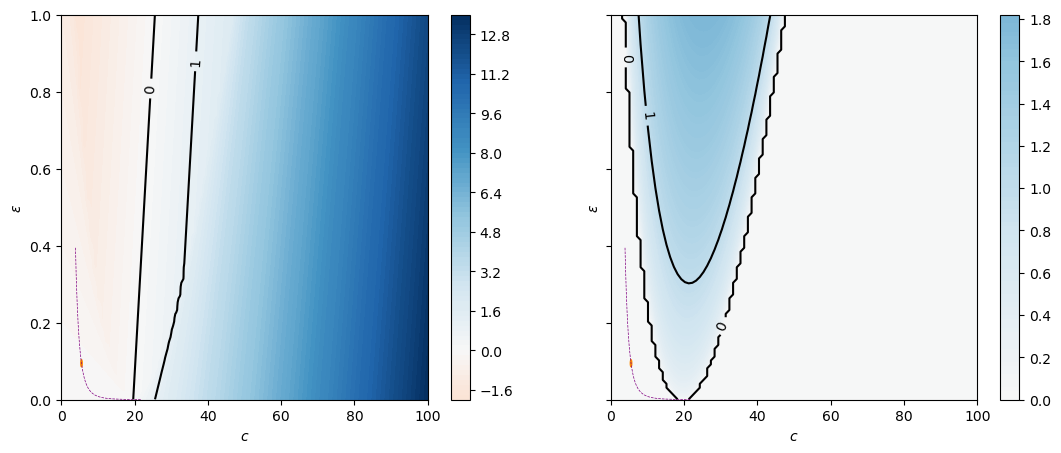

In [27]:
c_map = 5.48681
c_frac_err = 0.03699*1.96


centre = [c_map, epsilon_map]
width = c_frac_err*c_map 
height = epsilon_frac_err*epsilon_map

ratios = np.linspace(0.7, 4, 100)
c_traj = c_map*ratios
epsilon_traj = epsilon_map/ratios**4 


fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(13, 5))
im = axes[0].contourf(cs, epsilons, Re, levels=100, vmin=-np.max(Re), vmax=np.max(Re), cmap='RdBu')

ellipse =  Ellipse(centre, width, height, fill=True, color='darkorange')
axes[0].plot(c_traj, epsilon_traj, '--', color='purple', linewidth=0.5)
axes[0].add_patch(ellipse)
axes[0].set_xlabel(r'$c$')
axes[0].set_ylabel(r'$\epsilon$')
fig.colorbar(im, ax=axes[0])
CS = axes[0].contour(cs, epsilons, Re, levels=[0, 1], colors='black')
axes[0].clabel(CS, inline=True, fontsize=10)

im = axes[1].contourf(cs, epsilons, Im, levels=100, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar(im, ax=axes[1])
CS = axes[1].contour(cs, epsilons, Im, levels=[0, 1], colors='black')
axes[1].clabel(CS, inline=True, fontsize=10)
axes[1].set_xlabel(r'$c$')
axes[1].set_ylabel(r'$\epsilon$')
ellipse =  Ellipse(centre, width, height, fill=True, color='darkorange')
axes[1].add_patch(ellipse)
axes[1].plot(c_traj, epsilon_traj, '--', color='purple', linewidth=0.5)

axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 1])
plt.savefig('Figures/param_sweep_c_epsilon.pdf')
plt.show() 

In [14]:
class nonlinear_model(): 
    
    def __init__(self, params):
        self.J, B = convert_params(params)
        self.b = params[4]
        self.c = params[3] 
        self.B = B 
        
    def evolve(self, T, dt, n_frames, n_repeats):
        results = [] 
        for n in range(n_repeats): 
            y = np.zeros((2))
            res = np.zeros((n_frames, 2))
            for i in range(n_frames):
                for j in range(int(T/n_frames/dt)):
                    self._update(y, dt)
                res[i] = np.copy(y)
            results.append(res.T) 
        return results 


    def _update(self, y, dt):
        det = self.J @ y 
        det[1] -= self.b * det[0]**3 
        Bt = get_B(self.B, self.b, self.c, det[0])
        sto = np.sqrt(dt)*np.random.multivariate_normal([0, 0], Bt)
        y += det*dt + sto 

In [28]:
# [ 0.09473  2.38254  0.16884  5.48681 32.81625  0.02554  0.74518]
mu = 0.16884
c = 5.48681
gamma = 2.38254 + c*mu
epsilon = 0.09473
Dh = 0.02554
Dp = 0.74518
b = 32.81625

dt = 3.3e-3
n_frames = int(5000)
T = n_frames*0.033
n_repeats = 3

ratios = [1.2, 1, 0.9, 0.68]
tests = [[epsilon/r**4, gamma, mu/r**2, c*r, b*r**3, Dh, Dp] for r in ratios]

results = [] 
for params in tests:    
    J = get_J(params) 
    eigvals = np.linalg.eigvals(J)
    print(np.max(eigvals))
    m = nonlinear_model(params)
    res = m.evolve(T, dt, n_frames, n_repeats)[0]
    results.append(res)

-0.059921788597891545
-0.13375426431080006
-0.2164163621296158
(-1.194819740557934+0.19602466480423983j)


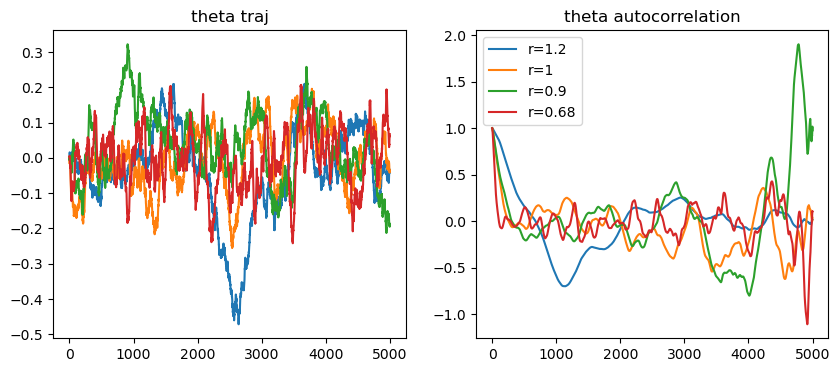

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for (i, res) in enumerate(results): 
    axes[0].plot(res[0], c=plt.cm.tab10(i))

    corr = find_auto_corr(res[0]-np.mean(res[0]))
    corr /= corr[0]
    axes[1].plot(corr, label='r={}'.format(ratios[i]), c=plt.cm.tab10(i))
    
axes[0].set_title('theta traj')
axes[1].set_title('theta autocorrelation')
plt.legend()
plt.show()